## **CNN with Regularization (TensorFlow)**

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
--- Training Baseline CNN ---
Epoch 1/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8120 - loss: 0.5106 - val_accuracy: 0.8784 - val_loss: 0.3405 - learning_rate: 0.0010
Epoch 2/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8871 - loss: 0.3052 - val_accuracy: 0.8946 - val_loss: 0.2913 - learning_rate: 0.0010
Epoch 3/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9053 - loss: 0.2523 - val_accuracy: 0.8988 - val_loss: 0.2830 - learning_rate: 0.0010
Epoch 4/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9180 - loss: 0.2218 - val_accuracy: 0.9093 - val_loss: 0.2380 - learning_rate: 0.0010
Epoch 5/30
750/750 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.9273 - loss: 0.1953 - val_accuracy: 0.9157 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 6/30
750/75

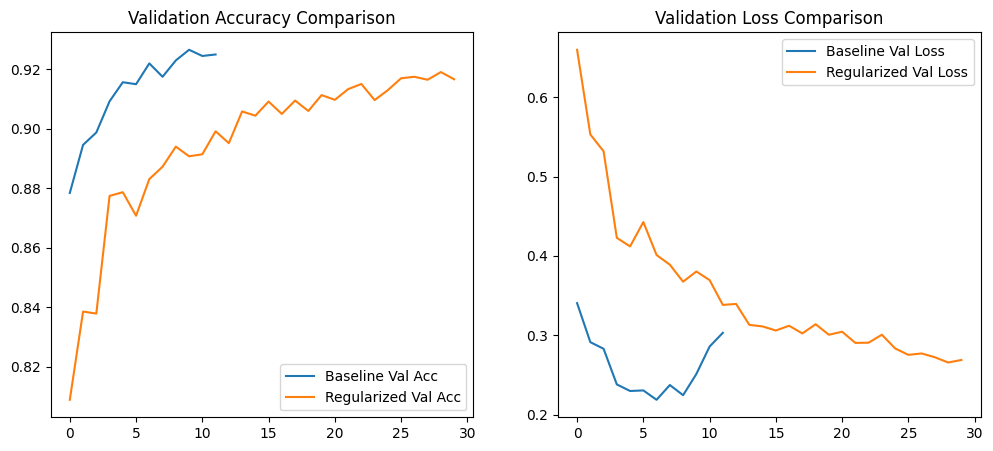

Baseline Test Accuracy: 91.51%
Regularized Test Accuracy: 91.29%


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np

# 1. Load Data (Fashion MNIST as recommended)
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalize and Reshape
x_train = x_train.reshape((-1, 28, 28, 1)).astype('float32') / 255.0
x_test = x_test.reshape((-1, 28, 28, 1)).astype('float32') / 255.0

# One-hot encoding
y_train_cat = tf.keras.utils.to_categorical(y_train, 10)
y_test_cat = tf.keras.utils.to_categorical(y_test, 10)

# 2. Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.04), # approx 15 degrees
    layers.RandomZoom(0.1),
])

# 3. Build CNN Model (As per assignment specs)
def build_cnn(use_reg=False):
    model = models.Sequential()
    
    # Input & Augmentation
    model.add(layers.Input(shape=(28, 28, 1)))
    if use_reg:
        model.add(data_augmentation)

    # Conv Block 1: 32 Filters
    model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Conv Block 2: 64 Filters
    model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    
    # Conv Block 3: 128 Filters
    model.add(layers.Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten & Dense
    model.add(layers.Flatten())
    
    # Regularization parameters
    l2_val = 0.001 if use_reg else 0.0
    drop_1 = 0.5 if use_reg else 0.0
    drop_2 = 0.3 if use_reg else 0.0

    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_val)))
    if use_reg: model.add(layers.Dropout(drop_1))
    
    model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_val)))
    if use_reg: model.add(layers.Dropout(drop_2))
    
    model.add(layers.Dense(10, activation='softmax'))
    
    return model

# 4. Training Configuration
def train_model(model_name, use_reg):
    print(f"--- Training {model_name} ---")
    model = build_cnn(use_reg)
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2)
    ]
    
    history = model.fit(x_train, y_train_cat, 
                        epochs=30, 
                        batch_size=64, 
                        validation_split=0.2, 
                        callbacks=callbacks,
                        verbose=1)
    return history, model

# Run Experiment 1: Baseline (No Regularization)
hist_base, model_base = train_model("Baseline CNN", use_reg=False)

# Run Experiment 2: Regularized (Augmentation + Dropout + L2)
hist_reg, model_reg = train_model("Regularized CNN", use_reg=True)

# 5. Visualization & Comparison
plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(hist_base.history['val_accuracy'], label='Baseline Val Acc')
plt.plot(hist_reg.history['val_accuracy'], label='Regularized Val Acc')
plt.title('Validation Accuracy Comparison')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(hist_base.history['val_loss'], label='Baseline Val Loss')
plt.plot(hist_reg.history['val_loss'], label='Regularized Val Loss')
plt.title('Validation Loss Comparison')
plt.legend()
plt.show()

# Final Evaluation
loss_b, acc_b = model_base.evaluate(x_test, y_test_cat, verbose=0)
loss_r, acc_r = model_reg.evaluate(x_test, y_test_cat, verbose=0)

print(f"Baseline Test Accuracy: {acc_b*100:.2f}%")
print(f"Regularized Test Accuracy: {acc_r*100:.2f}%")